In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import scipy as sp
from scipy.sparse import kron, eye, diags
import math as mt

# **Exercise 1**

## **c**

In [36]:
""" Original Function"""
def f(x):
    return np.exp(np.cos(x))

""" Second Derivative of Function """
def ddf(x):
    return np.exp(np.cos(x))*(-np.cos(x) +  np.sin(x)**2)

""" Coefficients of the FDM """
def fdcoeffV(k,xbar,x):
    n = len(x)
    A = np.ones((n,n))
    xrow = (x-xbar).transpose()
    for i in range(2,n+1):
        A[i-1,:] = (xrow**(i-1)/mt.factorial(i-1))
    b = np.zeros((n,1))
    b[k] = 1
    c = np.linalg.solve(A, b)
    
    return c

""" Calculates the 2nd derivative """
def update_value(x,c):
    result = 0
    for i in range(len(x)):
        result = result + c[i]*f(x[i])
    
    return result

In [37]:
"""
LET'S TEST CONVERGENCE
"""
s = np.arange(2,24+1,1)
h = 1/(2**s)

eps = 2.220446049250313e-16
k = 2
xbar = 0

# Actual solution
ddf_bar = ddf(xbar)


TE_C = np.zeros((len(h),1))
TE_OC = TE_C.copy()

for i in range(len(h)):
    x_C = np.arange(xbar-2*h[i],xbar+2*h[i] + h[i],h[i])
    x_OC = np.arange(xbar-4*h[i],xbar + h[i],h[i])
    coef_C = fdcoeffV(k,xbar,x_C)
    coef_OC = fdcoeffV(k,xbar,x_OC)
    d2f_dx2_C = update_value(x_C, coef_C)
    d2f_dx2_OC = update_value(x_OC, coef_OC)
    TE_C[i] = np.abs(ddf_bar-d2f_dx2_C)
    TE_OC[i] = np.abs(ddf_bar-d2f_dx2_OC)

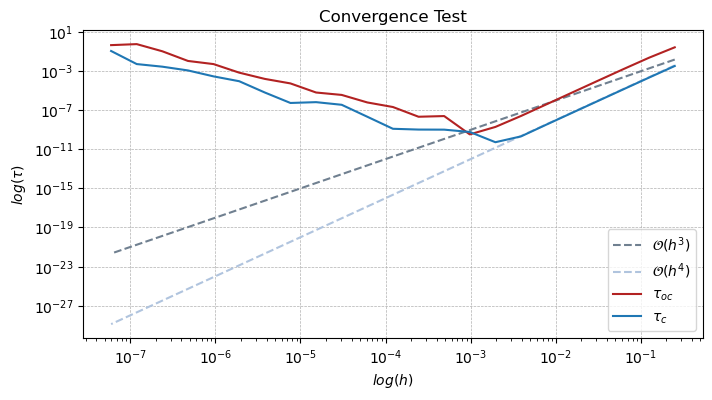

In [38]:
fig1, axes = plt.subplots(nrows=1,ncols=1,figsize=(8,4),dpi=100)

axes.loglog(h, h**3, linestyle='--', label=r'$\mathcal{O}(h^3)$',color='slategrey')
axes.loglog(h, h**4, linestyle='--', label=r'$\mathcal{O}(h^4)$', color='lightsteelblue')
axes.loglog(h, TE_OC, linestyle='-', label=r'$\tau_{oc}$', color='firebrick')
axes.loglog(h, TE_C, linestyle='-', label=r'$\tau_{c}$')
axes.set_xlabel(r'$log(h)$')
axes.set_ylabel(r'$log(\tau)$')
axes.set_title(r'Convergence Test')
axes.legend()
axes.grid(True, linestyle="--",linewidth=0.5)

# fig1.savefig('Assignement1_d.png', bbox_inches='tight')

## **Roundoff vs Truncation Error**

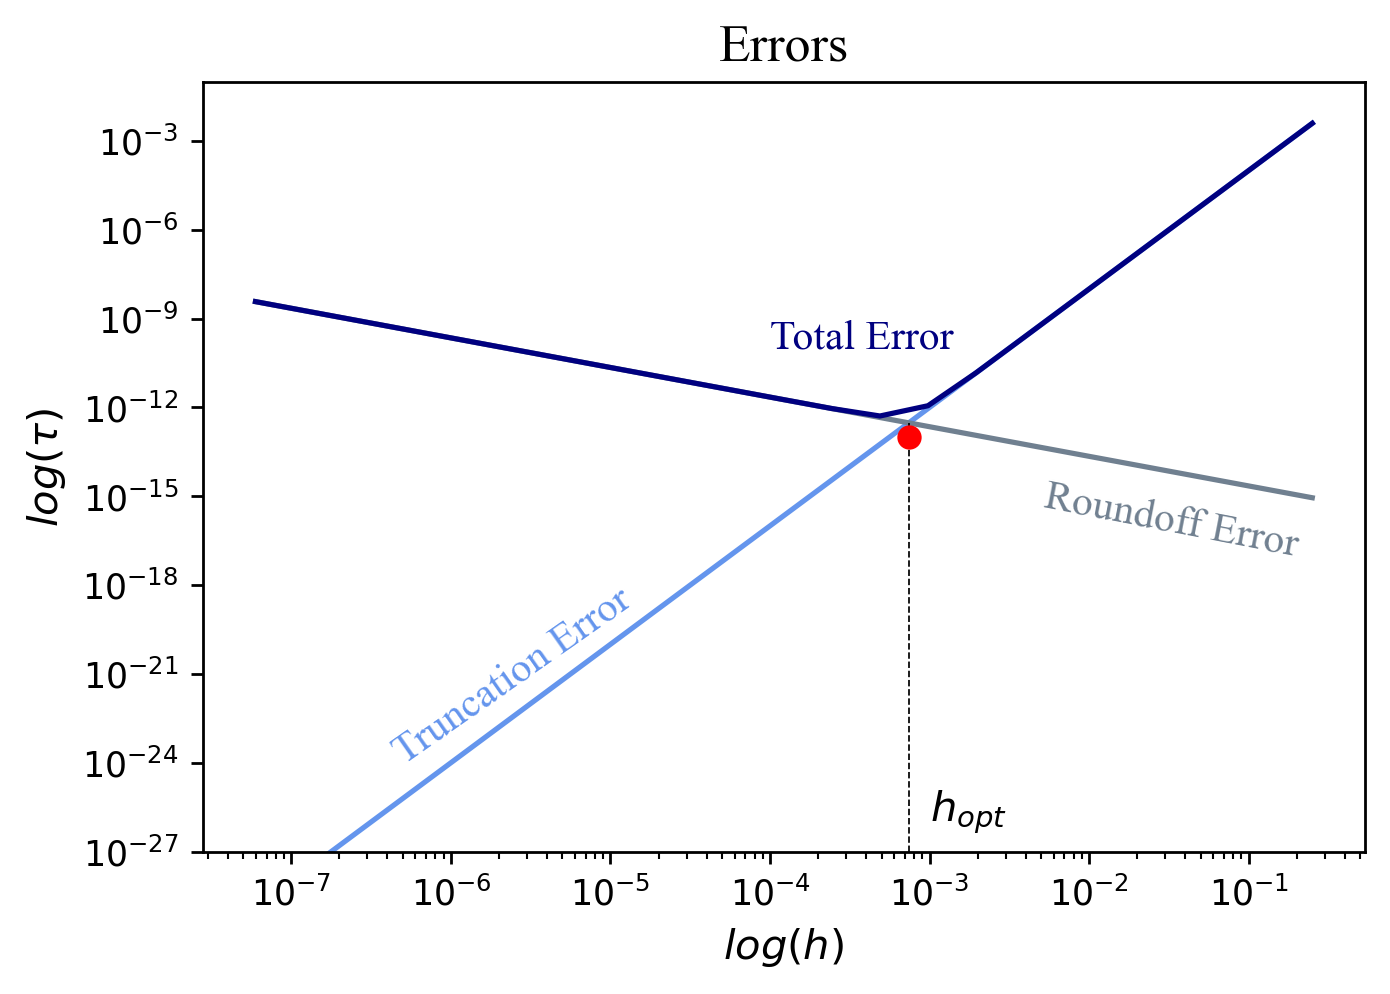

In [39]:
csfont = {'fontname':'Times New Roman'}
fig = plt.figure(figsize=(6,4),dpi=250)
plt.loglog(h, h**4, linestyle='-', label=r'$\mathcal{O}(h^4)$', color='cornflowerblue')
plt.loglog(h, eps/h, linestyle='-', label=r'$\mathcal{O}(1/h)$', color='slategray')
plt.loglog(h, eps/h + h**4, linestyle='-', label=r'$\mathcal{O}(1/h)$', color='navy')
plt.vlines(eps**(1/5),1e-27,3e-13,linestyle='--',color='k',lw=0.5)
plt.plot(eps**(1/5),1e-13,'ro')
plt.xlabel(r'$log(h)$',fontsize=12)
plt.ylabel(r'$log(\tau)$',fontsize=12)
plt.ylim([1e-27,1e-1])
plt.title('Errors',fontsize=15,**csfont)
ax = plt.gca()
text1 = ax.text(5e-3,1e-17,'Roundoff Error',color='slategray',fontsize=12,**csfont)
text1.set_rotation(-11)
text2 = plt.text(4e-7,1e-24,'Truncation Error',color='cornflowerblue',fontsize=12,**csfont)
text2.set_rotation(35) 
text3 = ax.text(1e-4,1e-10,'Total Error',color='navy',fontsize=12,**csfont)
text4 = ax.text(1e-3,1e-26,r'$h_{opt}$',color='k',fontsize=12,**csfont)
#fig.savefig('Assignement1_d_error.png', bbox_inches='tight')

# **Exercise 2a: Newton-Raphson for non-linear system**

In [40]:
""" INITIAL GUESS """
def initial_guess(x):
    xbar = 0.5 * (a-b-alpha+beta)
    w_0 = 0.5 * (a+b-alpha-beta)
    return x - xbar + w_0*np.tanh(w_0*(x-xbar)/(2*eps))

In [41]:
""" COMPUTE G """
def G(u):
    N = len(u)
    G = np.zeros(N)
    for i in range(N):
        u_i = u[i]
        u_prev = u[i-1] if i>0 else alpha
        u_next = u[i+1] if i<N-1 else beta
    
        # Update G function
        G[i] = (eps/h**2) * (u_next-2*u_i+u_prev) + u_i * ((u_next-u_prev)/(2*h) - 1)
    
    return G

In [42]:
""" JACOBIAN """
def J(u):
    N = len(u)
    J = np.zeros((N,N))
    
    for i in range(N):
        u_i = u[i]
        u_prev = u[i-1] if i>0 else alpha
        u_next = u[i+1] if i<N-1 else beta
        
        # Diagonal
        J[i,i] = -2*eps/h**2 + 1/(2*h) * (u_next-u_prev) - 1
        
        # Off diagonal up
        if i < N-1:
            J[i,i+1] = eps/h**2 + u_i/(2*h)
        
        # Off diagonal down
        if i > 0:
            J[i,i-1] = eps/h**2 - u_i/(2*h)
        
    return J

In [43]:
""" Newton-Raphson """
def Newton_Raphson_Systems(G,J,u0,tol=1e-7,num_iter=100):
    u = u0.copy()
    iteration = 0
    
    while iteration < num_iter:
        jacobian = J(u)
        Fu = G(u)
        du = np.linalg.solve(jacobian, -Fu)
        
        u_new = u + du
        
        if np.linalg.norm(du, 2) < tol:            
            print(f"Newton-Raphson converged in {iteration+1} iterations.")
            return u_new
        
        iteration =+ 1
        u = u_new
        
    print("Newton-Raphson did not converge.")
    return u_new

In [44]:
# Parameters
epsilon = np.array([.1,.3,.5,.8,1])
alpha = -1
beta = 1.5

# Domain
a = 0
b = 1

""" Mesh Construction """
N = 30  # Interior points
h = (b-a)/(N+1)
xi = np.arange(a,b+h,h)

In [45]:
epsilon

array([0.1, 0.3, 0.5, 0.8, 1. ])

In [46]:
# Initial Solution
eps = epsilon[0]
u0 = initial_guess(xi)[1:-1]
# Solution interior points
u_interior = Newton_Raphson_Systems(G, J, u0)
# Complete solution
u_sol = np.concatenate(([alpha], u_interior, [beta]))

Newton-Raphson converged in 2 iterations.


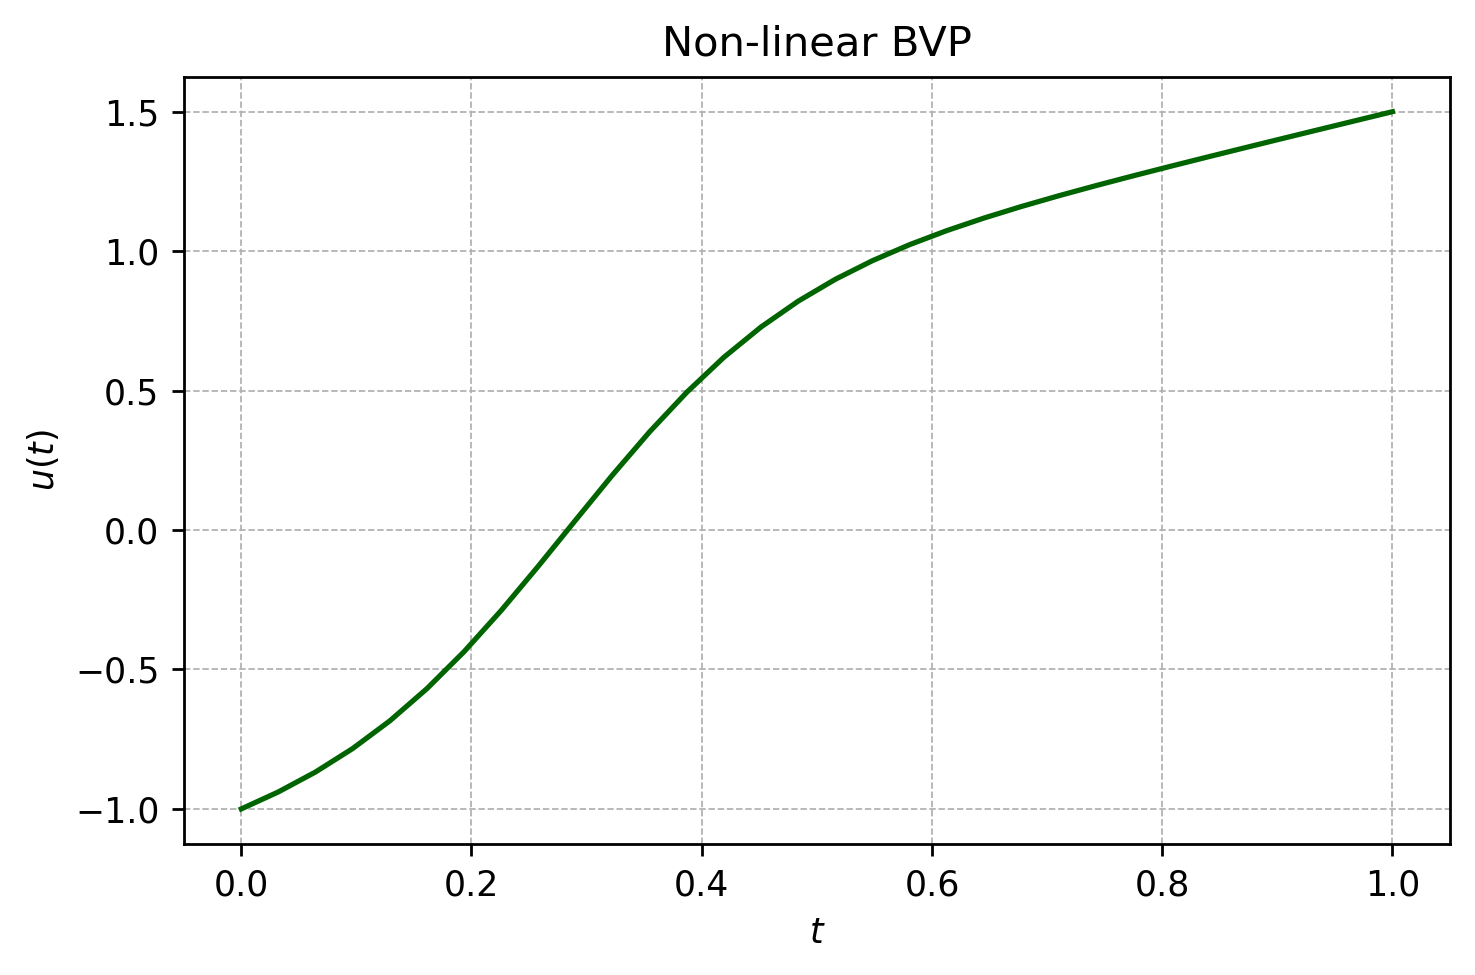

In [47]:
# Plots
fig = plt.figure(figsize=(6,4),dpi=250)
axes = plt.gca()
axes.plot(xi,u_sol,color='darkgreen',label='Solution')
#axes.plot(xi,initial_guess(xi),linestyle='--',color='slategray',label='Initial Guess')
axes.set_xlabel(r'$t$')
axes.set_ylabel(r'$u(t)$')
axes.set_title('Non-linear BVP')
axes.grid(True, linestyle="--",linewidth=0.5)
#axes.legend()

plt.tight_layout()
# fig.savefig('Assignement1_2b.png', bbox_inches='tight')

In [48]:
U = np.zeros((N+2,len(epsilon)))
for k, eps in enumerate(epsilon):
    """ Approximate initial solution """
    u0 = initial_guess(xi)[1:-1]
    # Solution interior points
    u_interior = Newton_Raphson_Systems(G, J, u0)
    u_sol = np.concatenate(([alpha], u_interior, [beta]))
    # save each solution
    U[:,k] = u_sol

Newton-Raphson converged in 2 iterations.
Newton-Raphson converged in 2 iterations.
Newton-Raphson converged in 2 iterations.
Newton-Raphson converged in 2 iterations.
Newton-Raphson converged in 2 iterations.


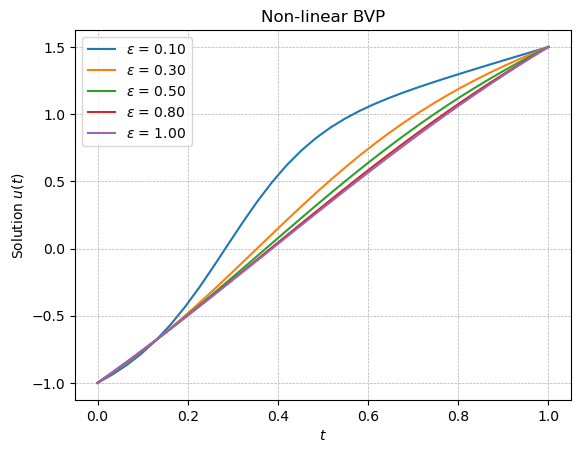

In [49]:
# Plots
fig = plt.figure()
axes = plt.gca()
for k in range(len(epsilon)):
    axes.plot(xi,U[:,k],label=rf'$\epsilon$ = {epsilon[k]:.2f}')

axes.set_xlabel(r'$t$')
axes.set_ylabel(r'Solution $u(t)$')
axes.set_title('Non-linear BVP')
axes.legend()
axes.grid(True, linestyle="--",linewidth=0.5)
# fig.savefig('Assignement1_2b.png', bbox_inches='tight')

# **Exercise 2b: 5- and 9-point Laplacian**

## **2b-c: 5-point**

In [2]:
# System Matrix for 5-point stencil (interior points)
def poisson5(m):
    e = np.ones(m)
    S = diags([e, -2*e, e], [-1, 0, 1], shape=(m, m))
    I = eye(m)
    A = kron(I, S) + kron(S, I)
    A = (m + 1) ** 2 * A
    return A

# Laplacian of the exact solution
def analytical_laplacian(x, y):
    pi = np.pi
    return -32 * pi**2 * np.sin(4 * pi * (x + y)) - 16 * pi**2 * (x**2 + y**2) * np.cos(4 * pi * x * y)

# Exact solution
def exact_solution(x, y):
    pi = np.pi
    return np.sin(4 * pi * (x + y)) + np.cos(4 * pi * x * y)

# Include BC in the right-hand side f
def f_BC_5p(f,h,u_exact):
    # 5 point nodes coefficients
    main_coeff = 1/h**2
    # Left boundary
    f[1:m+1, 1] = f[1:m+1, 1] - main_coeff * u_exact[1:m+1, 0]
    # Right boundary
    f[1:m+1, m] = f[1:m+1, m] - main_coeff * u_exact[1:m+1, m+1]
    # Bottom boundary
    f[1, 1:m+1] = f[1, 1:m+1] - main_coeff * u_exact[0, 1:m+1]
    # Top boundary
    f[m, 1:m+1] = f[m, 1:m+1] - main_coeff * u_exact[m+1, 1:m+1]
    return f


In [156]:
# Mesh
m = 100
h = 1 / (m + 1)
x = np.linspace(0, 1, m+2)
y = np.linspace(0, 1, m+2)

X, Y = np.meshgrid(x, y)
# Compute exact solution and Laplacian
u_exact = exact_solution(X, Y)
exact_laplacian = analytical_laplacian(X, Y)

# Construct right-hand side (vectorized)
f = exact_laplacian.copy()

# Extract only the interior points
f_complete = f_BC_5p(f,h,u_exact) 
f = f_complete[1:-1, 1:-1]

# Construct the matrix A
sparse_A = poisson5(m)
#A_array = sparse_A.toarray()

# Flatten to match dimensionality
f_flatten = f.flatten('F')

# Solve system
#u_app = np.linalg.solve(A_array, f_flatten)

# Solve system with sparse matrix
u_app = sp.sparse.linalg.spsolve(sparse_A, f_flatten)

# Fill the full grid with computed values
U = u_exact.copy()
U[1:-1, 1:-1] = u_app.reshape((m, m), order='F')

# Compute error
error = U - u_exact
error = np.abs(error)

### Solution

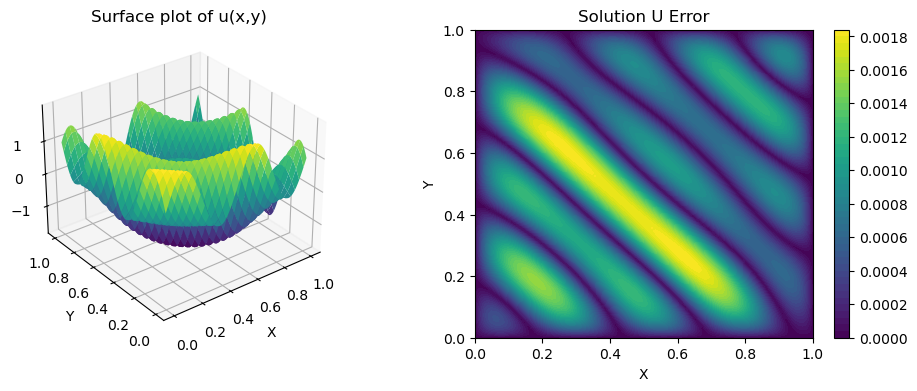

In [157]:
# Create figure with 2 columns
fig = plt.figure(figsize=(12, 4), dpi=100)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1],wspace=0.2)

# ----- Subplot 1: 3D Surface Plot -----
ax1 = fig.add_subplot(gs[0], projection='3d')
ax1.plot_surface(X, Y, U, cmap='viridis')

# Reverse axes for MATLAB-like orientation
ax1.set_xlim(ax1.get_xlim()[::-1])  
ax1.set_ylim(ax1.get_ylim()[::-1])  

# Set view to match MATLAB
ax1.view_init(elev=30, azim=90-37.5)

# Labels
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('u(X,Y)')
ax1.set_title('Surface plot of u(x,y)')



# ----- Subplot 2: Contour Plot -----
ax2 = fig.add_subplot(gs[1])
contour = ax2.contourf(X, Y, error, levels=50, cmap='viridis')
fig.colorbar(contour, ax=ax2)  # Add colorbar
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Solution U Error')

# Save figur
# fig.savefig('2b_c_Solution.png', bbox_inches='tight', dpi=200)

#plt.tight_layout()

plt.show()

### Convergence Test. Second-Order accuracy

In [53]:
s = np.arange(3,10+1,1)
h_values = 1/(2**s)
m_values = (1/h_values - 1).astype('int')

In [54]:
# Initialize max norm error for each h_value
error_total_5p = np.zeros(len(h_values))

In [55]:
for i, h in enumerate(h_values):
    m = (1/h - 1).astype('int')
    x = np.linspace(0, 1, m+2)
    y = np.linspace(0, 1, m+2)
    
    X, Y = np.meshgrid(x, y)
    
    # Compute exact solution and Laplacian
    u_exact = exact_solution(X, Y)
    exact_laplacian = analytical_laplacian(X, Y)

    # Construct right-hand side (vectorized)
    f = exact_laplacian.copy()
    
    # Extract only the interior points
    f_complete = f_BC_5p(f,h,u_exact) 
    f = f[1:-1, 1:-1]
    
    # Construct the matrix A
    sparse_A = poisson5(m)
    #A_array = sparse_A.toarray()
    
    # Flatten to match dimensionality
    f_flatten = f.flatten('F')
    
    # Solve system
    u_app = sp.sparse.linalg.spsolve(sparse_A, f_flatten)
    
    # Fill the full grid with computed values
    U = u_exact.copy()
    U[1:-1, 1:-1] = u_app.reshape((m, m), order='F')
    
    # Compute error
    error = U[1:-1,1:-1] - u_exact[1:-1,1:-1]

    # Total error
    error_total_5p[i] = np.max(np.abs(error))

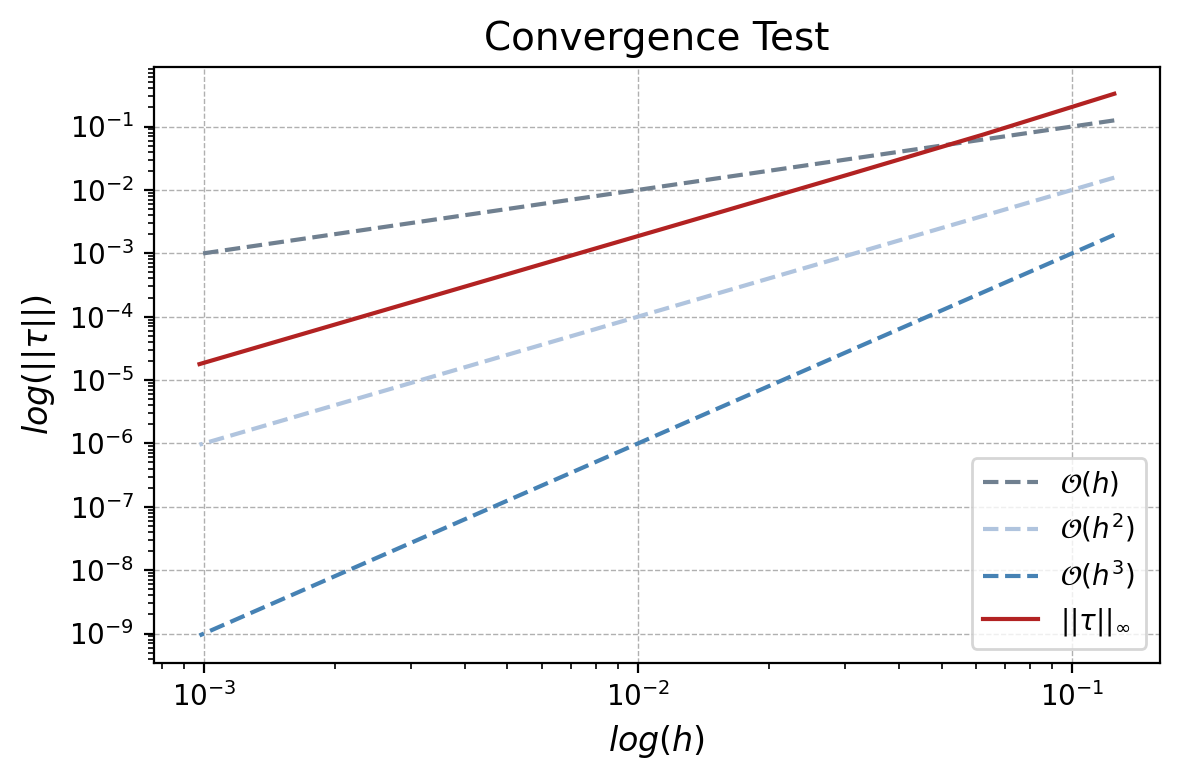

In [56]:
fig = plt.figure(figsize=(6,4),dpi=200)
axes = plt.gca()

axes.loglog(h_values, h_values**1, linestyle='--', label=r'$\mathcal{O}(h)$',color='slategrey')
axes.loglog(h_values, h_values**2, linestyle='--', label=r'$\mathcal{O}(h^2)$', color='lightsteelblue')
axes.loglog(h_values, h_values**3, linestyle='--', label=r'$\mathcal{O}(h^3)$', color='steelblue')
axes.loglog(h_values, error_total_5p, linestyle='-', label=r'$||\tau||_{\infty}$', color='firebrick')
axes.set_xlabel(r'$log(h)$',fontsize=12)
axes.set_ylabel(r'$log(||\tau||)$',fontsize=12)
axes.set_title('Convergence Test',fontsize=14)
axes.legend()
axes.grid(True, linestyle="--",linewidth=0.5)
plt.tight_layout()

#fig.savefig('2b_c_Convergence.png', bbox_inches='tight', dpi=200)

## **2b-d: 9-point Deferred Correction**

In [3]:
def poisson9(m):
    e = np.ones(m)
    S = diags([-e, -10*e, -e], [-1, 0, 1], shape=(m, m))
    I = diags([-1/2*e, e, -1/2*e], [-1, 0, 1], shape=(m, m))
    A = kron(I, S) + kron(S, I)
    A = 1/6*(m + 1) ** 2 * A
    return A

# Laplacian of the exact solution
def analytical_laplacian(x, y):
    pi = np.pi
    # return 0 + 0*x*y
    return -32 * pi**2 * np.sin(4 * pi * (x + y)) - 16 * pi**2 * (x**2 + y**2) * np.cos(4 * pi * x * y)

# Exact solution
def exact_solution(x, y):
    pi = np.pi
    # return 1+ 1*x
    return np.sin(4 * pi * (x + y)) + np.cos(4 * pi * x * y)

# Compute Laplacian of f for deferred correction
def laplacian_f(x,y):
    pi = np.pi
    return 64*pi**2*(4*pi**2*x**4*np.cos(4*pi*x*y) + 8*pi**2*x**2*y**2*np.cos(4*pi*x*y) + 8*pi*x*y*np.sin(4*pi*x*y) + 4*pi**2*y**4*np.cos(4*pi*x*y) + 16*pi**2*np.sin(pi*(4*x + 4*y)) - np.cos(4*pi*x*y))

    
# Apply boundary conditions (vectorized) ADAPT TO 9 LAPLACIAN
def f_BC_9pt(f, h, u_exact):
    
    # 9-point nodes coefficients
    main_coeff = 4/(6*h**2)
    diag_coeff = 1/(6*h**2)
    
    # Left boundary
    f[1:m+1, 1] = f[1:m+1, 1] - main_coeff * u_exact[1:m+1, 0]
    f[1:m+1, 1] = f[1:m+1, 1] - diag_coeff * (u_exact[0:m, 0] + u_exact[2:m+2, 0])
    
    # Right boundary
    f[1:m+1, m] = f[1:m+1, m] - main_coeff * u_exact[1:m+1, m+1]
    f[1:m+1, m] = f[1:m+1, m] - diag_coeff * (u_exact[0:m, m+1] + u_exact[2:m+2, m+1])
    
    # Bottom boundary
    f[1, 1:m+1] = f[1, 1:m+1] - main_coeff * u_exact[0, 1:m+1]
    f[1, 1:m+1] = f[1, 1:m+1] - diag_coeff * (u_exact[0, 0:m] + u_exact[0, 2:m+2])
    
    # Top boundary
    f[m, 1:m+1] = f[m, 1:m+1] - main_coeff * u_exact[m+1, 1:m+1]
    f[m, 1:m+1] = f[m, 1:m+1] - diag_coeff * (u_exact[m+1, 0:m] + u_exact[m+1, 2:m+2])
    
    # # TERM IN THE CORNERS
    f[1,1] += diag_coeff * u_exact[0,0]
    f[m,m] += diag_coeff * u_exact[m+1,m+1]
    f[1,m] += diag_coeff * u_exact[0,m+1]
    f[m,1] += diag_coeff * u_exact[m+1,0]

    return f

In [58]:
# Mesh
m = 50
h = 1 / (m + 1)
x = np.linspace(0, 1, m+2)
y = np.linspace(0, 1, m+2)
X, Y = np.meshgrid(x, y)

# Compute exact solution and Laplacian
u_exact = exact_solution(X, Y)
exact_laplacian = analytical_laplacian(X, Y)

# Construct right-hand side (vectorized)
f = exact_laplacian.copy()

# Apply boundary conditions
f_complete = f_BC_9pt(f, h, u_exact)


# Apply deferred correction
f_corrected = f_complete + (h**2 / 12) * laplacian_f(X, Y)

# Extract only the interior points
f = f_corrected[1:-1, 1:-1]

# Construct the matrix A
sparse_A = poisson9(m)

# Flatten to match dimensionality
f_flatten = f.flatten('F')

# Solve system
u_app = sp.sparse.linalg.spsolve(sparse_A, f_flatten)

# Fill the full grid with computed values
U = u_exact.copy()
U[1:-1, 1:-1] = u_app.reshape((m, m), order='F')

# Compute error
error = np.abs(U - u_exact)

### Solution

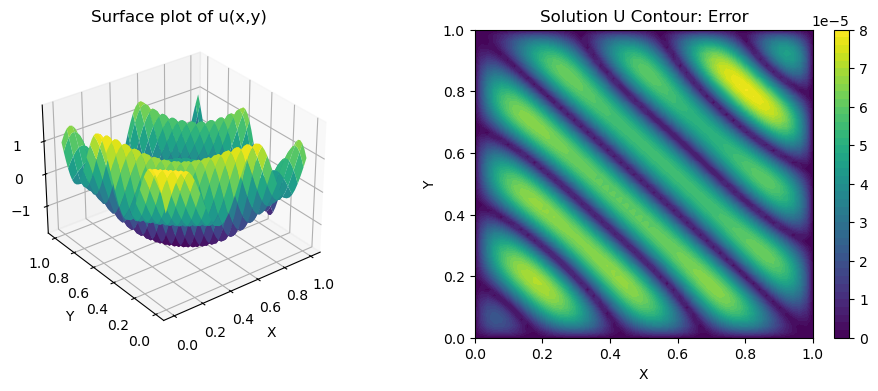

In [59]:
# Create figure with 2 columns
fig = plt.figure(figsize=(12, 4), dpi=100)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1],wspace=0.2)

# ----- Subplot 1: 3D Surface Plot -----
ax1 = fig.add_subplot(gs[0], projection='3d')
ax1.plot_surface(X, Y, U, cmap='viridis')

# Reverse axes for MATLAB-like orientation
ax1.set_xlim(ax1.get_xlim()[::-1])  
ax1.set_ylim(ax1.get_ylim()[::-1])  

# Set view to match MATLAB
ax1.view_init(elev=30, azim=90-37.5)

# Labels
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('u(X,Y)')
ax1.set_title('Surface plot of u(x,y)')



# ----- Subplot 2: Contour Plot -----
ax2 = fig.add_subplot(gs[1])
contour = ax2.contourf(X, Y, error, levels=50, cmap='viridis')
fig.colorbar(contour, ax=ax2)  # Add colorbar
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Solution U Contour: Error')

# Save figur
# fig.savefig('2b_c_Solution.png', bbox_inches='tight', dpi=200)

#plt.tight_layout()

plt.show()

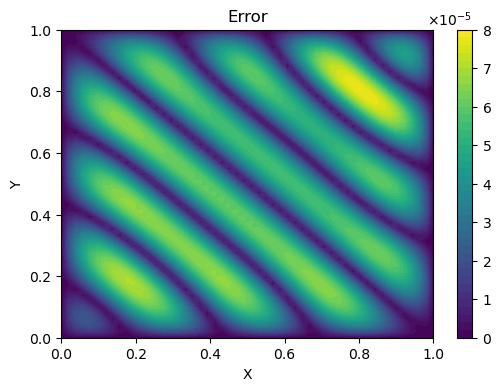

In [60]:
fig = plt.figure(figsize=(6, 4))
axes = plt.gca()
contour = axes.contourf(X, Y, error, levels=50, cmap='viridis')
#fig.colorbar(contour, ax=axes)  # Add colorbar
axes.set_xlabel('X')
axes.set_ylabel('Y')
axes.set_title('Error')

import matplotlib.ticker as ticker
# Format colorbar in scientific notation
cbar = plt.colorbar(contour)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))  # Adjust power limits for scientific notation
cbar.ax.yaxis.set_major_formatter(formatter)
# fig.savefig('2b_cd_Error_9p.png', bbox_inches='tight', dpi=200)

### Convergence Test: Deferred Correction

In [61]:
s = np.arange(3,10+1,1)
h_values = 1/(2**s)
m_values = (1/h_values - 1).astype('int')

# Initialize max norm error for each h_value
error_total_9p = np.zeros(len(h_values))

for i, h in enumerate(h_values):
    m = (1/h - 1).astype('int')
    x = np.linspace(0, 1, m+2)
    y = np.linspace(0, 1, m+2)
    
    X, Y = np.meshgrid(x, y)
    
    # Compute exact solution and Laplacian
    u_exact = exact_solution(X, Y)
    exact_laplacian = analytical_laplacian(X, Y)

    # Construct right-hand side (vectorized)
    f = exact_laplacian.copy()
    
    # Extract only the interior points
    f_complete = f_BC_9pt(f, h, u_exact)
    f_corrected = f_complete + (h**2 / 12) * laplacian_f(X,Y)
    f = f_corrected[1:-1, 1:-1]
    
    # Construct the matrix A
    sparse_A = poisson9(m)
    #A_array = sparse_A.toarray()
    
    # Flatten to match dimensionality
    f_flatten = f.flatten('F')
    
    # Solve system
    u_app = sp.sparse.linalg.spsolve(sparse_A, f_flatten)
    
    # Fill the full grid with computed values
    U = u_exact.copy()
    U[1:-1, 1:-1] = u_app.reshape((m, m), order='F')
    
    # Compute error
    error = U[1:-1,1:-1] - u_exact[1:-1,1:-1]

    # Total error
    # error_total[i] = np.max(np.abs(error))
    error_total_9p[i] = np.linalg.norm((U - u_exact).flatten(), np.inf)

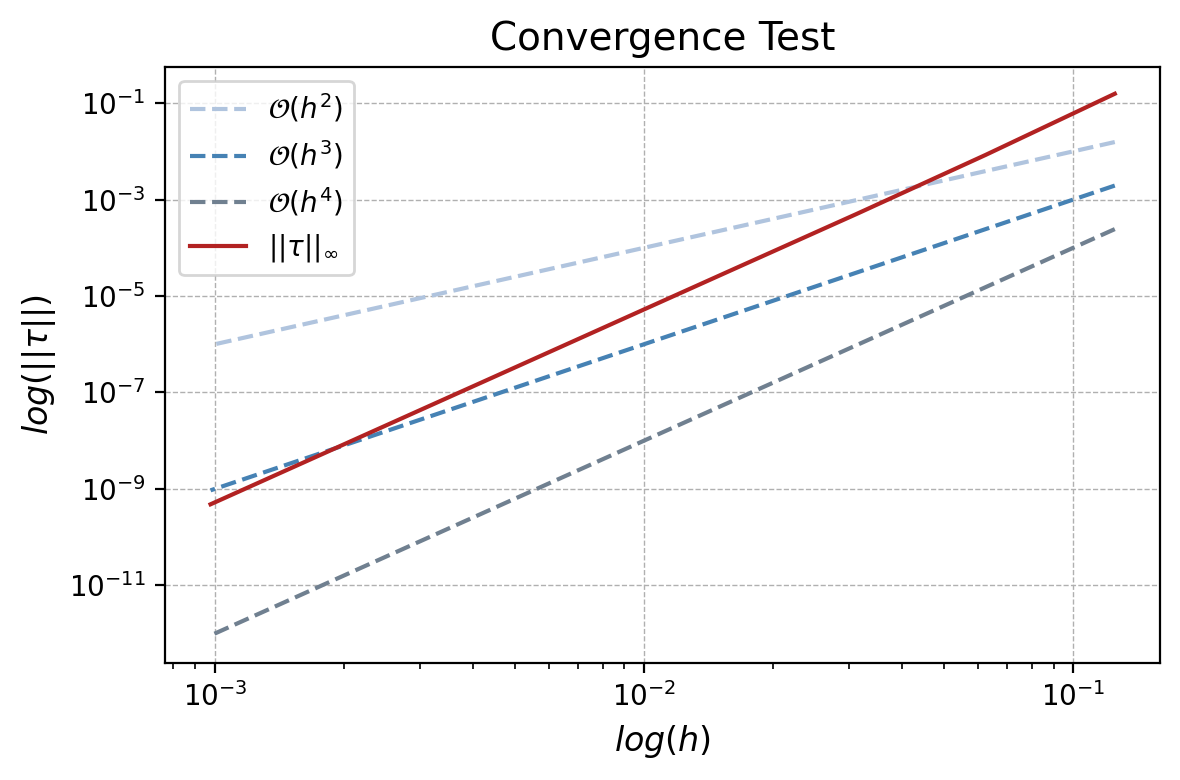

In [62]:
fig = plt.figure(figsize=(6,4),dpi=200)
axes = plt.gca()

axes.loglog(h_values, h_values**2, linestyle='--', label=r'$\mathcal{O}(h^2)$', color='lightsteelblue')
axes.loglog(h_values, h_values**3, linestyle='--', label=r'$\mathcal{O}(h^3)$', color='steelblue')
axes.loglog(h_values, h_values**4, linestyle='--', label=r'$\mathcal{O}(h^4)$', color='slategray')
axes.loglog(h_values, error_total_9p, linestyle='-', label=r'$||\tau||_{\infty}$', color='firebrick')
axes.set_xlabel(r'$log(h)$',fontsize=12)
axes.set_ylabel(r'$log(||\tau||)$',fontsize=12)
axes.set_title('Convergence Test',fontsize=14)
axes.legend()
axes.grid(True, linestyle="--",linewidth=0.5)
plt.tight_layout()

### Covergence Test: 5-point vs 9-point DC

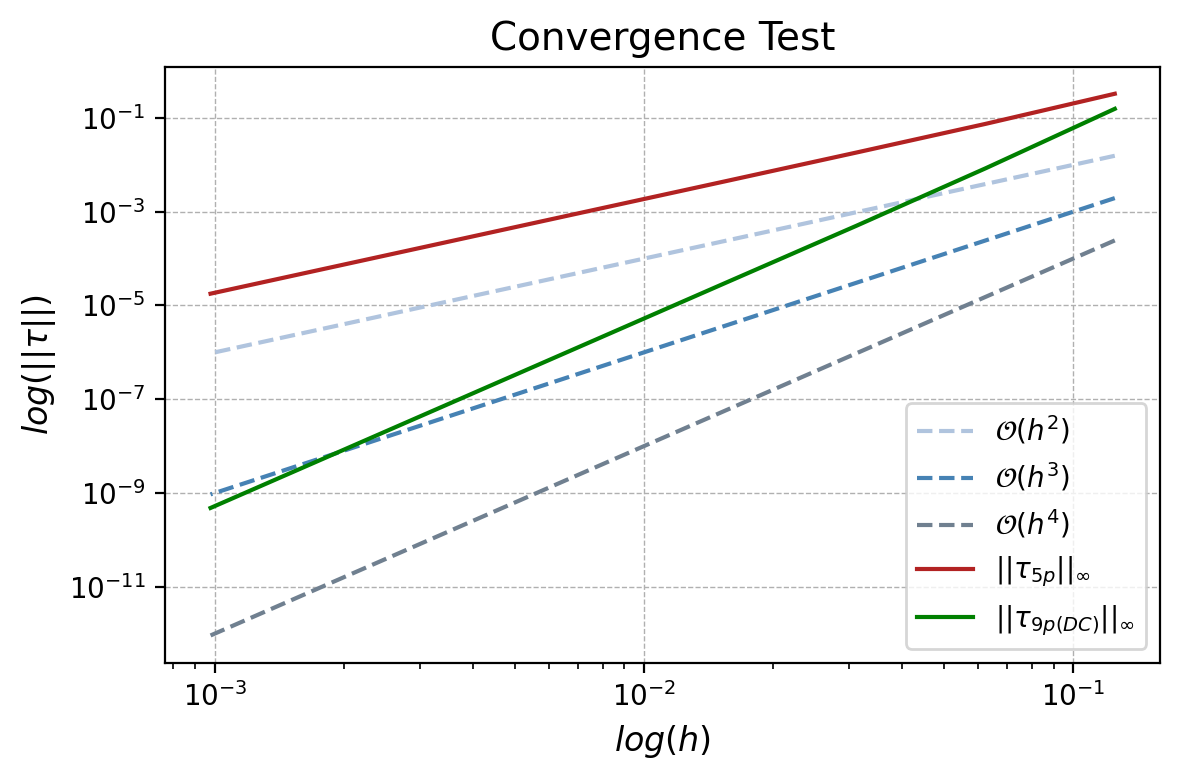

In [63]:
fig = plt.figure(figsize=(6,4),dpi=200)
axes = plt.gca()
axes.loglog(h_values, h_values**2, linestyle='--', label=r'$\mathcal{O}(h^2)$', color='lightsteelblue')
axes.loglog(h_values, h_values**3, linestyle='--', label=r'$\mathcal{O}(h^3)$', color='steelblue')
axes.loglog(h_values, h_values**4, linestyle='--', label=r'$\mathcal{O}(h^4)$', color='slategray')
axes.loglog(h_values, error_total_5p, linestyle='-', label=r'$||\tau_{5p}||_{\infty}$', color='firebrick')
axes.loglog(h_values, error_total_9p, linestyle='-', label=r'$||\tau_{9p(DC)}||_{\infty}$', color='green')
axes.set_xlabel(r'$log(h)$',fontsize=12)
axes.set_ylabel(r'$log(||\tau||)$',fontsize=12)
axes.set_title('Convergence Test',fontsize=14)
axes.legend()
axes.grid(True, linestyle="--",linewidth=0.5)
plt.tight_layout()

# Save figur
# fig.savefig('2b_d_Convergence.png', bbox_inches='tight', dpi=200)

# **Excercise 3: Iterative Solvers in 2D**

## **Matrix-free 5-point Laplacian**

### **Matrix free multiplication: Amult**

In [3]:
def Amult(U):
    m = int(np.sqrt(len(U)))
    h = 1/(m+1)
    
    # Reshape U into a 2D array for easier indexing
    U = U.reshape((m, m), order='F')
    
    # Create expanded U to allow slicing
    expanded_U = np.zeros((m+2,m+2))
    expanded_U[1:-1,1:-1] = U
    
    # Initialize product array
    AU = np.zeros_like(U)
    
    # Stencil terms
    left_term   = expanded_U[1:-1, :-2]
    right_term  = expanded_U[1:-1, 2:]   
    bottom_term = expanded_U[:-2, 1:-1]  
    top_term    = expanded_U[2:, 1:-1]   
    self_term   = -4*U                 

    #Solution
    AU = (left_term+right_term+bottom_term+top_term+self_term)/h**2  
    
    return -AU.flatten('F')

### **Conjugate Gradient** : matrix-free

In [4]:
# Mesh
m = 50
h = 1 / (m + 1)
x = np.linspace(0, 1, m+2)
y = np.linspace(0, 1, m+2)

X, Y = np.meshgrid(x, y)

# Compute exact solution and Laplacian
u_exact = exact_solution(X, Y)
exact_laplacian = analytical_laplacian(X, Y)

# Construct right-hand side (vectorized)
f = exact_laplacian.copy()

# Extract only the interior points
f_complete = f_BC_5p(f,h,u_exact) 
f = f_complete[1:-1, 1:-1]

# Construct the matrix A

# Flatten to match dimensionality
f_flatten = f.flatten('F')

# Solve system
u_app = np.ones(m**2)

# Track convergence history
# Callback function to compute and store the residual norm at each iteration (it returns the solution u_k)
residuals = []

def callback(u_k):
    r_k = f_flatten + A_operator.matvec(u_k)  # Correctly compute the residual using matvec()
    norm_residual = np.linalg.norm(r_k)  # Compute the residual norm
    residuals.append(norm_residual)  # Store it
    
A_operator = sp.sparse.linalg.LinearOperator((m**2, m**2), matvec=Amult)
u_app, _ = sp.sparse.linalg.cg(A_operator,-f_flatten, rtol=1e-8, callback=callback)

# Fill the full grid with computed values
U = u_exact.copy()
U[1:-1, 1:-1] = u_app.reshape((m, m), order='F')

# Compute error
error = np.abs(U - u_exact)

#### **Convergence History (CG)**

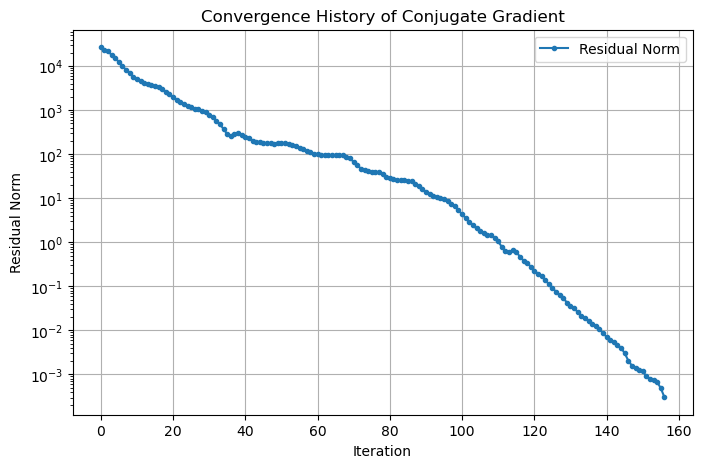

In [5]:
plt.figure(figsize=(8,5))
plt.semilogy(residuals, label="Residual Norm", marker='.')  # Log scale for clear decay
plt.xlabel("Iteration")
plt.ylabel("Residual Norm")
plt.title("Convergence History of Conjugate Gradient")
plt.legend()
plt.grid()
plt.show()

As we can observe in the plot, we achieve a almost linear convergence.

#### **Convergence Rate Estimate (CG)**

We have to check that the operator AU is symmetric

In [6]:
def symmetry_A_operator(A_operator):

    # Generate two random vectors
    x = np.random.rand(m**2)
    y = np.random.rand(m**2)

    # Compute Ax and Ay
    Ax = A_operator.matvec(x)
    Ay = A_operator.matvec(y)

    # Compute symmetry condition: x^T * (A y) vs. y^T * (A x)
    symmetry_error = np.abs(np.dot(x, Ay) - np.dot(y, Ax)) / np.abs(np.dot(x, Ay))

    # Print result
    print(f"Symmetry Error = {symmetry_error}")

    # Set a small threshold for numerical errors
    if symmetry_error < 1e-10:
        print("A is symmetric")
    else:
        print("A is not symmetric")


Estimate Convergence Rate for CG

In [7]:
from scipy.sparse.linalg import eigsh

number_iterations = len(residuals)

# Let's check if A is symmetric
symmetry_A_operator(A_operator)

# Compute the largest and smallest eigenvalues of A
lambda_max, _ = eigsh(A_operator, k=1, which='LM')
lambda_min, _ = eigsh(A_operator, k=1, which='SM')

# Condition number and convergence rate
kappa_A = lambda_max / lambda_min
rho_CG = (np.sqrt(kappa_A) - 1) / (np.sqrt(kappa_A) + 1)

print(f"Condition Number: {kappa_A[0]:.2e}")
print(rf"Theoretical Convergence Rate: $\rho = {rho_CG[0]:.4f}$")


Symmetry Error = 6.364574207441124e-16
A is symmetric
Condition Number: 1.05e+03
Theoretical Convergence Rate: $\rho = 0.9402$


## **Under/over-relaxed Jacobi smoothing**

### **Eigenvalues and $\omega_{opt}$**

The optimal w is 0.6733668341708543


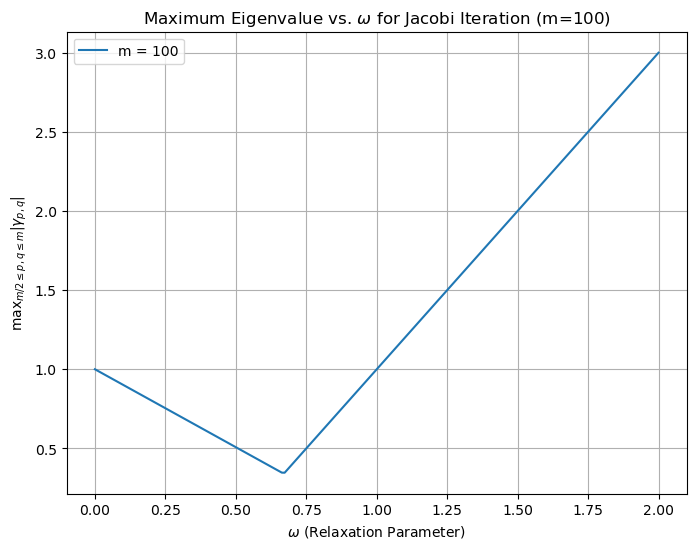

In [4]:
def compute_max_gamma(m, h, omega):
    
    gamma_max = 0
    for p in range(m // 2, m + 1):
        for q in range(m // 2, m + 1):
            # gamma_pq = 1 + omega/2 * (np.cos(p * np.pi * h) + np.cos(q * np.pi * h) - 1)
            gamma_pq = 1 - omega + omega/2 * (np.cos(p * np.pi * h) + np.cos(q * np.pi * h))
            gamma_max = max(gamma_max, abs(gamma_pq))
    return gamma_max

def underrelaxed_jacobi_eigenvalues(m):

    omega_vals = np.linspace(0, 2, 200)
    h = 1 / (m + 1)

    max_eigenvalues = [compute_max_gamma(m, h, omega) for omega in omega_vals]
    
    plt.figure(figsize=(8,6))
    plt.plot(omega_vals, max_eigenvalues, label=f'm = {m}')

    print(f'The optimal w is {omega_vals[np.argmin(max_eigenvalues)]}')
    
    plt.xlabel(r'$\omega$ (Relaxation Parameter)')
    plt.ylabel(r'max$_{m/2 \leq p,q \leq m} | \gamma_{p,q} |$')
    plt.title(rf'Maximum Eigenvalue vs. $\omega$ for Jacobi Iteration (m={m})')
    plt.legend()
    plt.grid()
    plt.show()

    return omega_vals[np.argmin(max_eigenvalues)]

# Example usage: Experiment with a specific value of m
w_opt = underrelaxed_jacobi_eigenvalues(100)

### **Matrix-free relaxed Jacobi**

Let's compute the function for the relaxed Jacobi method

In [5]:
def smooth(U,omega,F):

    # Initialize residuals
    residuals = []

    # Iteration parameters
    tolerance = 1e-8
    max_iterations = int(1e5)

    # Mesh size
    m = int(np.sqrt(len(U)))
    h = 1 / (m + 1)

    # Initial residual
    residuals.append(np.linalg.norm(F + Amult(U)))

    # Iteration
    for k in range(1,max_iterations):

        # Update the solution
        U_new = U + omega * h**2 /4 * ( -Amult(U) - F)

        # Calculate the residual
        residuals.append(np.linalg.norm(F + Amult(U)))

        # Stopping criterion
        if residuals[k]/residuals[0] < tolerance:
            print(f"Converged in {k+1} iterations with final residual {residuals[k]:.2e}")
            return U_new, residuals
            break
        
        U = U_new

    print(f"Converged in {k+1} iterations with final residual {residuals[k]:.2e}")
    return U, residuals

Full Solution Code:

In [28]:
# Mesh
m = 50
h = 1 / (m + 1)
x = np.linspace(0, 1, m+2)
y = np.linspace(0, 1, m+2)

X, Y = np.meshgrid(x, y)

# Compute exact solution and Laplacian
u_exact = exact_solution(X, Y)
exact_laplacian = analytical_laplacian(X, Y)

# Construct right-hand side (vectorized)
f = exact_laplacian.copy()

# Extract only the interior points
f_complete = f_BC_5p(f,h,u_exact) 
f = f_complete[1:-1, 1:-1]

# Construct the matrix A

# Flatten to match dimensionality
f_flatten = f.flatten('F')

# Solve system
u_app = np.zeros(m**2)

# Underrelaxed-Jacobi iteration
u_app, residuals = smooth(u_app, w_opt, f_flatten)

# Fill the full grid with computed values
U = u_exact.copy()
U[1:-1, 1:-1] = u_app.reshape((m, m), order='F')

# Compute error
error = np.abs(U - u_exact)

Converged in 9493 iterations with final residual 4.56e-04


As we observe, the more nodes we have in our grid, the more number of iterations the iterative method will need to get some established accuracy.

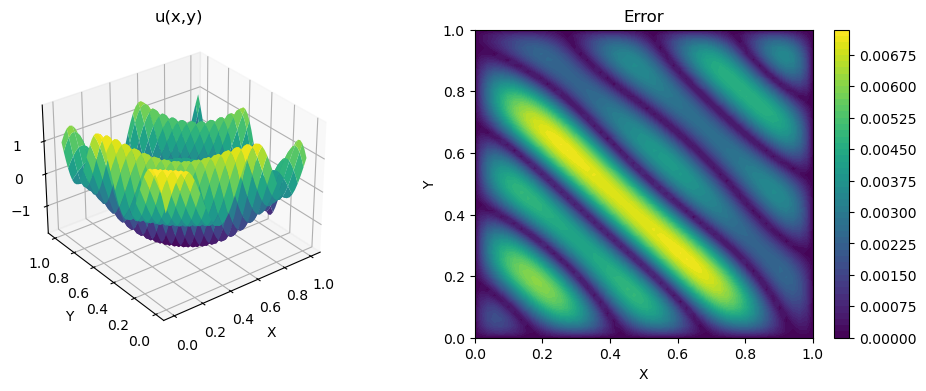

In [29]:
# Create figure with 2 columns
fig = plt.figure(figsize=(12, 4), dpi=100)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1],wspace=0.2)

# ----- Subplot 1: 3D Surface Plot -----
ax1 = fig.add_subplot(gs[0], projection='3d')
ax1.plot_surface(X, Y, U, cmap='viridis')

# Reverse axes for MATLAB-like orientation
ax1.set_xlim(ax1.get_xlim()[::-1])  
ax1.set_ylim(ax1.get_ylim()[::-1])  

# Set view to match MATLAB
ax1.view_init(elev=30, azim=90-37.5)

# Labels
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('u(X,Y)')
ax1.set_title('u(x,y)')


# ----- Subplot 2: Contour Plot -----
ax2 = fig.add_subplot(gs[1])
contour = ax2.contourf(X, Y, error, levels=50, cmap='viridis')
fig.colorbar(contour, ax=ax2)  # Add colorbar
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Error')

# Save figur
# fig.savefig('2b_c_Solution.png', bbox_inches='tight', dpi=200)

#plt.tight_layout()

plt.show()

Let's plot the residuals and check we have a linear convergence

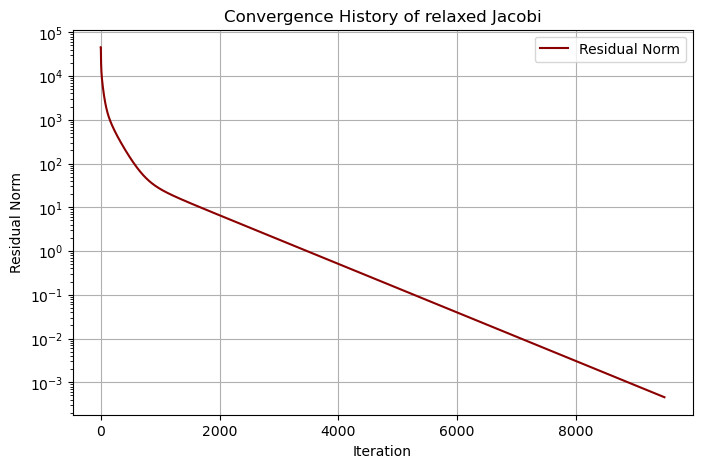

In [12]:
plt.figure(figsize=(8,5))
plt.semilogy(residuals, label="Residual Norm",color='darkred')  # Log scale for clear decay
plt.xlabel("Iteration")
plt.ylabel("Residual Norm")
plt.title("Convergence History of relaxed Jacobi")
plt.legend()
plt.grid()
plt.show()

## **Multigrid solver**

### **1-Dimensional Multigrid**

In [22]:
# Exact Solution

a = .5

def psi(x):
    return 20*np.pi*x**3

def psidot(x):
    return 3*20*np.pi*x**2

def psiddot(x):
    return 2*3*20*np.pi*x

def f(x):
    return -20 + a*psiddot(x) * np.cos(psi(x)) - a*psidot(x)**2*np.sin(psi(x))

def u(x):
    return 1 + 12*x - 10*x**2 + a*np.sin(psi(x))

In [ ]:
def coarsen(r):
    m = len(r)
    m_coarse = int ((m - 1) / 2)
    h_coarse = 1 / (m_coarse + 1)
    # r_coarse = r[1::2]      # Direct interpolation to coarsen grid

    # Better interpolation to coarsen grid
    # Slice values
    left_term = r[0:-2:2]
    center_term= r[1:-1:2]
    right_term = r[2::2]    
    r_coarse = (1/4) * left_term + (1/2) * center_term + (1/4) * right_term
    
    assert len(r_coarse) == m_coarse  # gives an error if this does not apply
    
    return r_coarse

def interpolate(r_coarse,m):   

    # Coarse grid
    m_coarse = len(r_coarse)
    h_coarse = 1 / (m_coarse + 1)
    
    # Create coarse grid matrix
    A_coarse_diag_main = np.full(m_coarse, -2 / h_coarse**2)
    A_coarse_diag_off = np.full(m_coarse - 1, 1 / h_coarse**2)
    A_coarse = sp.sparse.diags([A_coarse_diag_off, A_coarse_diag_main, A_coarse_diag_off], offsets=[-1, 0, 1], format='csc')

    # Solve the coarse problem
    e_coarse = sp.sparse.linalg.spsolve(A_coarse, -r_coarse)

    # Project back onto the fine grid
    e = np.zeros(m)
    e[1::2] = e_coarse

    # Interpolation
    for i in range(0, m, 2):
        e_left = e[i - 1] if i > 0 else 0
        e_right = e[i + 1] if i < m - 1 else 0
        e[i] = (e_left + e_right) / 2
        
    # # Interpolation for even indices, ensuring boundary handling
    # e[2:-1:2] = 0.5 * (e[1:-2:2] + e[3::2])  # Avoiding boundaries
    # e[0] = 0.5 * e[1]  # Left boundary handling
    # e[-1] = 0.5 * e[-2]  # Right boundary handling
        
    return e

In [24]:
# Mesh
k = 7
m = 2**k - 1
h = 1/(m+1)

# Create sparse matrix A
diag_main = np.full(m, -2 / h**2)
diag_off = np.full(m - 1, 1 / h**2)
A = sp.sparse.diags([diag_off, diag_main, diag_off], offsets=[-1, 0, 1], format='csc')

X = np.linspace(0+h, 1-h, m)

# Right hand side with BC
F = f(X)
F[0] = F[0] - u(0)/h**2
F[-1] = F[-1] - u(1)/h**2

# Exact solution
Uhat = u(X)
Ehat = sp.sparse.linalg.spsolve(A,F) - Uhat

# Jacobi method setup
M = sp.sparse.diags(A.diagonal(), format='csc')
N = M - A
G = sp.sparse.linalg.spsolve(M, N)
b = sp.sparse.linalg.spsolve(M, F)

# Relaxation factor
omega = 2 / 3

# Initialize U2
U = 1 + 2 * X

# Multigrid Steps

# 1. Pre-Smoothing (Iterative Jacobi method: 10 iterations)
for i in range(1, 11):
    U = (1 - omega) * U + omega * (G @ U + b)
    E = U - Uhat
    
# 2. Compute residual
r = F - A @ U

# 3. Coarsen the residual
r_coarse = coarsen(r)

# 4. Solve Error in coarse & Interpolate to fine
e = interpolate(r_coarse, m)

# 5. Correct the solution
U = U - e
E = U - Uhat

print(np.linalg.norm(U))
print(np.linalg.norm(E))

# 6. Post-Smoothing (Iterative Jacobi method: 10 iterations)
for i in range(1, 11):
    U = (1 - omega) * U + omega * (G @ U + b)
    E = U - Uhat
    
print(np.linalg.norm(U))
print(np.linalg.norm(E))

43.454876564100914
0.25444286709683345
43.45694640542238
0.25747205926454314


### **2-Dimensional Multigrid**

Exact Solution:

In [7]:
# Exact solution
def exact_solution(x, y):
    pi = np.pi
    # return 1+ 1*x
    return np.sin(4 * pi * (x + y)) + np.cos(4 * pi * x * y)

# Analytical solution for the Laplacian
def analytical_laplacian(x, y):
    pi = np.pi
    # return 0 + 0*x*y
    return -32 * pi**2 * np.sin(4 * pi * (x + y)) - 16 * pi**2 * (x**2 + y**2) * np.cos(4 * pi * x * y)

Right-hand side

In [ ]:
# Include BC in the right-hand side f (5-point Laplacian)
def f_BC_5p(f,u_exact):
    # 5 point nodes coefficients
    main_coeff = 1/h**2
    # Left boundary
    f[1:m+1, 1] = f[1:m+1, 1] - main_coeff * u_exact[1:m+1, 0]
    # Right boundary
    f[1:m+1, m] = f[1:m+1, m] - main_coeff * u_exact[1:m+1, m+1]
    # Bottom boundary
    f[1, 1:m+1] = f[1, 1:m+1] - main_coeff * u_exact[0, 1:m+1]
    # Top boundary
    f[m, 1:m+1] = f[m, 1:m+1] - main_coeff * u_exact[m+1, 1:m+1]
    
    return f

Matrix-free multiplication

In [ ]:
def Amult(U):
    m = int(np.sqrt(len(U)))
    h = 1/(m+1)
    
    # Reshape U into a 2D array for easier indexing
    U = U.reshape((m, m), order='F')
    
    # Create expanded U to allow slicing
    expanded_U = np.zeros((m+2,m+2))
    expanded_U[1:-1,1:-1] = U
    
    # Initialize product array
    AU = np.zeros_like(U)
    
    # Stencil terms
    left_term   = expanded_U[1:-1, :-2]
    right_term  = expanded_U[1:-1, 2:]   
    bottom_term = expanded_U[:-2, 1:-1]  
    top_term    = expanded_U[2:, 1:-1]   
    self_term   = -4*U                 

    #Solution
    AU = (left_term+right_term+bottom_term+top_term+self_term)/h**2  
    
    return -AU.flatten('F')

In [47]:
# Under-relaxed Jacobi smoothing
def smooth(U,omega,nsmooth,F):

    # Initialize residuals
    residuals = []

    # Iteration parameters
    tolerance = 1e-8
    max_iterations = nsmooth

    # Mesh size
    m = int(np.sqrt(len(U)))
    h = 1 / (m + 1)

    # Initial residual
    residuals.append(np.linalg.norm(F + Amult(U)))

    # Iteration
    for k in range(1,max_iterations):

        # Update the solution
        U_new = U + omega * h**2 /4 * ( -Amult(U) - F)

        # Calculate the residual
        residuals.append(np.linalg.norm(F + Amult(U_new)))

        # Stopping criterion
        if residuals[k]/residuals[0] < tolerance:
            # print(f"Converged in {k+1} iterations with final residual {residuals[k]:.2e}")
            return U_new
            break
        
        U = U_new

    # print(f"Converged in {k+1} iterations with final residual {residuals[k]:.2e}")
    return U

Coarsen function:

In [107]:
# Coarsen function: fine grid to coarse grid
def coarsen(r):
    m = int(np.sqrt(len(r)))
    r = r.reshape((m, m), order='F')
    m_coarse = int((m - 1) / 2)
    
    # Direct Interpolation
    # r_coarse = r[1::2,1::2]      # Pick each two elements from the first one
    
    # Full-Weighting Interpolation
    r_coarse = (
        1/16 * r[0:-2:2, 0:-2:2] + 1/8 * r[1:-1:2, 0:-2:2] + 1/16 * r[2::2, 0:-2:2] +
        1/8  * r[0:-2:2, 1:-1:2] + 1/4  * r[1:-1:2, 1:-1:2] + 1/8  * r[2::2, 1:-1:2] +
        1/16 * r[0:-2:2, 2::2] + 1/8 * r[1:-1:2, 2::2] + 1/16 * r[2::2, 2::2]
    )
    
    return r_coarse.flatten('F')

Interpolate function:

In [ ]:
# Interpolate function: coarse grid to fine grid
def interpolate(e_coarse,m):
    
    # Grid properties
    m_coarse = int(np.sqrt(len(e_coarse)))
    h_coarse = 1 / (m_coarse + 1)    
    
    # Reshape for convenience
    e_coarse = e_coarse.reshape((m_coarse, m_coarse), order='F')

    # Project back onto the fine grid
    # We add the boundary nodes for easier indexing
    e = np.zeros((m+2,m+2))
    e[2:-2:2,2:-2:2] = e_coarse

    # Interpolation
    
    # FIRST SWEEP: Horizontal
    e[2:-2:2, 1:-1:2] = 1/2 * (e[2:-2:2, 0:-1:2] + e[2:-2:2, 2::2])
    
    # SECOND SWEEP: Vertical
    e[1:-1:2, 2:-2:2] = 1/2 * (e[0:-1:2, 2:-2:2] + e[2::2, 2:-2:2])
    
    # THIRD SWEEP: bilinear interpolation
    e[1:-1:2, 1:-1:2] = 1/4 * (e[1:-1:2, 0:-2:2] + e[1:-1:2, 2::2] + e[0:-2:2, 1:-1:2] + e[2::2, 1:-1:2])
    
    # Get only the interior points back
    e = e[1:-1,1:-1]
        
    return e.flatten('F')

**VCycle**

In [ ]:
# Recursive V-Cycle Solver
def Vcycle(U,omega,nsmooth,m,F):
    
    h = 1.0/(m+1)
    
    if m == 1:
        # We are at the coarsest level (1 node)
        
        # Create coarse grid matrix
        A_coarse = -4/(h**2)

        # Solve the coarse problem
        e_coarse = F/A_coarse
        
        U = e_coarse
        
    else:
        
        # 1. Pre-Smoothing
        U = smooth(U, omega, nsmooth, F)
        
        # 2. Compute Residual
        r = F + Amult(U)
        
        # 3. Coarsen Residual
        r_coarse = coarsen(r)
        
        # 4. Recurse to Vcycle
        mc = int(np.sqrt(len(r_coarse)))
        e_coarse = Vcycle(np.zeros_like(r_coarse), omega, nsmooth, mc, -r_coarse)
        
        # 5. Interpolate Error
        e = interpolate(e_coarse, m)
        
        # 6. Update Solution
        U -= e
        
        # 7. Post-Smoothing
        U = smooth(U, omega, nsmooth, F)    
    
    return U

The Vcycle must be run multiple times, until we obtain some tolerance.

In [ ]:
def outer_iteration(U, m, F):

    epsilon = 1.0e-10
    max_iter = 100

    for i in range(1, max_iter + 1):
        R = F + Amult(U)  # Residual (note the sign: F - AhU = F + Amult(U, m))
        rel_resid = np.linalg.norm(R, 2) / np.linalg.norm(F, 2)
        # print(f"*** Outer iteration: {i:3d}, rel. resid.: {rel_resid:.6e}")
        
        if rel_resid < epsilon:
            return U, i
        
        U = Vcycle(U, 2/3, 3, m, F)

    return U, i


Code:

In [102]:
# Mesh
import time
t1 = time.perf_counter()

m = 2**8-1
h = 1 / (m + 1)
x = np.linspace(0, 1, m+2)
y = np.linspace(0, 1, m+2)

X, Y = np.meshgrid(x, y)

# Compute exact solution and Laplacian
u_exact = exact_solution(X, Y)
exact_laplacian = analytical_laplacian(X, Y)

# Construct right-hand side (vectorized)
f = exact_laplacian.copy()

# Extract only the interior points
f_complete = f_BC_5p(f,u_exact) 
f = f_complete[1:-1, 1:-1]

# Flatten to match dimensionality
f_flatten = f.flatten('F')

# Solve system
u_app = np.zeros(m**2)  # Initial guess
# u_app = smooth(u_app, 2/3, 5000, f_flatten)

# Vcycle
# u_app = Vcycle(u_app, 2/3, 10, m, f_flatten)
u_app, i = outer_iteration(u_app, m, f_flatten)

# Fill the full grid with computed values
U = u_exact.copy()
U[1:-1, 1:-1] = u_app.reshape((m, m), order='F')

# Compute error
error = np.abs(U - u_exact)

t2 = time.perf_counter()
print(f'\nThe total time is: {t2-t1}')

print(f'\nThe error infinity norm is: {np.linalg.norm(error,np.inf)}')




The total time is: 0.29791959997965023

The error infinity norm is: 0.03398913598471505


Plot Results:

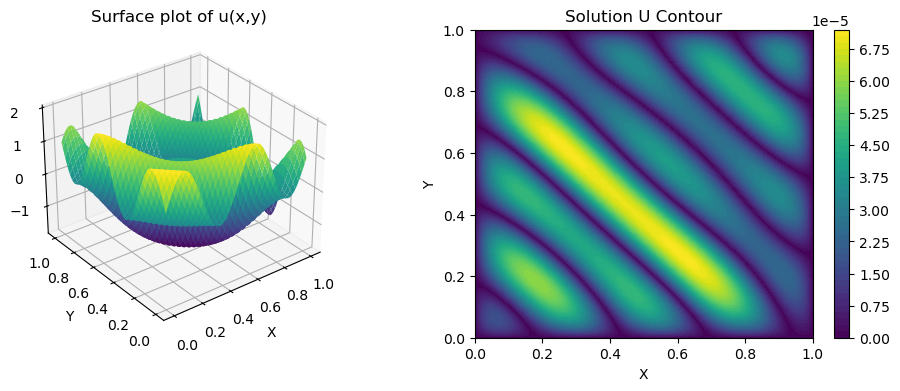

In [87]:
# Create figure with 2 columns
fig = plt.figure(figsize=(12, 4), dpi=100)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1],wspace=0.2)

# ----- Subplot 1: 3D Surface Plot -----
ax1 = fig.add_subplot(gs[0], projection='3d')
ax1.plot_surface(X, Y, U, cmap='viridis')

# Reverse axes for MATLAB-like orientation
ax1.set_xlim(ax1.get_xlim()[::-1])  
ax1.set_ylim(ax1.get_ylim()[::-1])  

# Set view to match MATLAB
ax1.view_init(elev=30, azim=90-37.5)

# Labels
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('u(X,Y)')
ax1.set_title('Surface plot of u(x,y)')

# ----- Subplot 2: Contour Plot -----
ax2 = fig.add_subplot(gs[1])
contour = ax2.contourf(X, Y, error, levels=50, cmap='viridis')
fig.colorbar(contour, ax=ax2)  # Add colorbar
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Solution U Contour')

plt.show()

Let's plot the outer iterations for different values of m

Text(0.5, 1.0, 'Outer Iterations vs m')

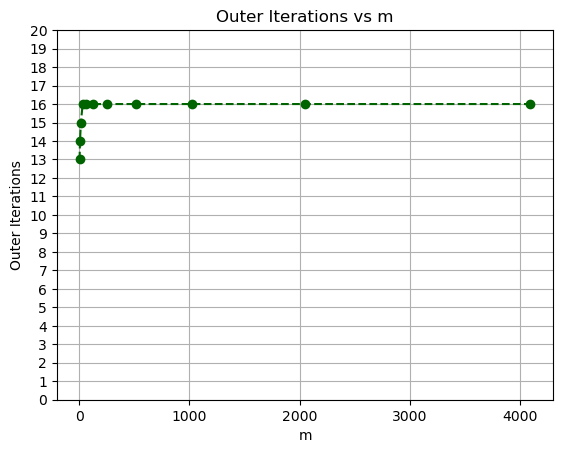

In [111]:
# Mesh
k_values = [2,3,4,5,6,7,8,9,10,11,12]
m_values = [2**k-1 for k in k_values]
outer_iterations_counts = []

for m in m_values:
    h = 1 / (m + 1)
    x = np.linspace(0, 1, m+2)
    y = np.linspace(0, 1, m+2)

    X, Y = np.meshgrid(x, y)

    # Compute exact solution and Laplacian
    u_exact = exact_solution(X, Y)
    exact_laplacian = analytical_laplacian(X, Y)

    # Construct right-hand side (vectorized)
    f = exact_laplacian.copy()

    # Extract only the interior points
    f_complete = f_BC_5p(f,u_exact) 
    f = f_complete[1:-1, 1:-1]

    # Flatten to match dimensionality
    f_flatten = f.flatten('F')

    # Solve system
    u_app = np.zeros(m**2)  # Initial guess

    # Vcycle
    # u_app = Vcycle(u_app, 2/3, 10, m, f_flatten)
    u_app, i = outer_iteration(u_app, m, f_flatten)

    outer_iterations_counts.append(i)

plt.figure()
plt.plot(m_values, outer_iterations_counts,'--o', color='darkgreen')
plt.xlabel('m')
plt.ylim([0,20])
plt.yticks(np.arange(0, 21, 1))
plt.ylabel('Outer Iterations')
plt.grid()
plt.title('Outer Iterations vs m')